In [60]:
from features import extract_tokens
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import preprocessing
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression , SGDClassifier
from sklearn.naive_bayes import MultinomialNB , ComplementNB
from sklearn.svm import LinearSVC , SVC
from sklearn.ensemble import VotingClassifier
from joblib import dump, load
from sklearn.feature_selection import SelectKBest, chi2

In [245]:
df = pd.read_csv("phishing_site_urls.csv")
df = df.drop_duplicates()
df["URL"].value_counts()

tommyhumphreys.com/                                                                                       2
amazon.ca/Rules-Game-Criterion-Collection/dp/B00005JLV6                                                   1
twitter.com/marypierce06                                                                                  1
sportsmansguide.com/net/cb/john-marshall-3x4-mossy-oak-new-break-up-camo-border-area-rug.aspx?a=387003    1
celebrityphotoz.com/Flora_Martinez/                                                                       1
                                                                                                         ..
www.paypal.com.home.cy-login.cgi.bin.secure-id.account.bandaemanuel.com.br/secure                         1
robertsoncustomcutlery.com/watsontac.htm                                                                  1
'www.gaoxiaowo.com/image/index.htm?ref=http\%3A\%2F\%2Fydqyyrrus.battle.net\%2Fd3\%2Fen\%2Findex'         1
thecanadianencyclopedia.com/

In [246]:
le = preprocessing.LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])
df

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,0
3,mail.printakid.com/www.online.americanexpress....,0
4,thewhiskeydregs.com/wp-content/themes/widescre...,0
...,...,...
516466,23.227.196.215/,0
516467,apple-checker.org/,0
516468,apple-iclods.org/,0
516469,apple-uptoday.org/,0


In [247]:
df.sample(frac=1).reset_index(drop=True)
y = df["Label"]
X = df.drop("Label" , axis=1)

Training Samples =  405756
Testing Samples =  101440


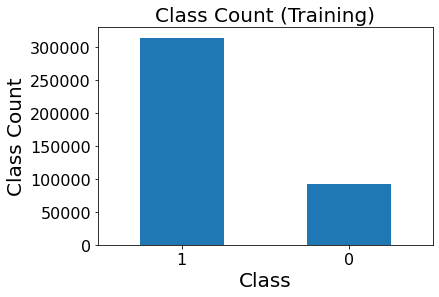

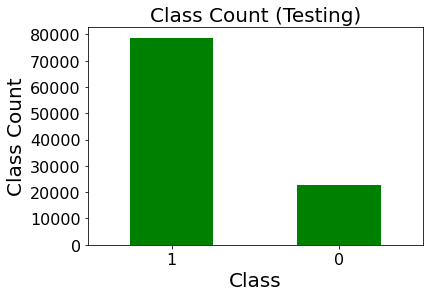

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Training Samples = " , len(X_train))
print("Testing Samples = " , len(X_test))

count_train_classes = pd.value_counts(y_train)
count_train_classes.plot(kind='bar', fontsize=16)
plt.title("Class Count (Training)", fontsize=20)
plt.xticks(rotation='horizontal')
plt.xlabel("Class", fontsize=20)
plt.ylabel("Class Count", fontsize=20)

plt.show()

count_test_classes = pd.value_counts(y_test)
count_test_classes.plot(kind='bar', fontsize=16, colormap='ocean')
plt.title("Class Count (Testing)", fontsize=20)
plt.xticks(rotation='horizontal')
plt.xlabel("Class", fontsize=20)
plt.ylabel("Class Count", fontsize=20)

plt.show()

In [249]:
count_vectorizer = CountVectorizer(tokenizer = extract_tokens)# Tokenizer
count_vectorizer_X_train = count_vectorizer.fit_transform(X_train["URL"])

tfidf_vectorizer = TfidfVectorizer(tokenizer = extract_tokens)
tfidf_vectorizer_X_train = tfidf_vectorizer.fit_transform(X_train["URL"])

In [250]:
dump(count_vectorizer, 'count_vectorizer.joblib')
dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

In [251]:
test_X_count = count_vectorizer.transform(X_test["URL"])
test_X_tfidf = tfidf_vectorizer.transform(X_test["URL"])

In [68]:
def generate_report(cmatrix, score, creport):
  """Generates and displays graphical reports
  Keyword arguments:
    cmatrix - Confusion matrix generated by the model
    score --- Score generated by the model
    creport - Classification Report generated by the model
    
  :Returns -- N/A
  """
  
  # Generate confusion matrix heatmap
  plt.figure(figsize=(5,5))
  sns.heatmap(cmatrix, 
              annot=True, 
              fmt="d", 
              linewidths=.5, 
              square = True, 
              cmap = 'Blues', 
              annot_kws={"size": 16}, 
              xticklabels=['bad', 'good'],
              yticklabels=['bad', 'good'])

  plt.xticks(rotation='horizontal', fontsize=16)
  plt.yticks(rotation='horizontal', fontsize=16)
  plt.xlabel('Actual Label', size=20);
  plt.ylabel('Predicted Label', size=20);

  title = 'Accuracy Score: {0:.4f}'.format(score)
  plt.title(title, size = 20);

  # Display classification report and confusion matrix
  print(creport)
  plt.show()
  

print("\n### Report Generator Defined ###\n")


### Report Generator Defined ###



In [69]:
count_vectorizer_X_train

<405756x730156 sparse matrix of type '<class 'numpy.int64'>'
	with 2950282 stored elements in Compressed Sparse Row format>

In [10]:
lgbm_clf = lgbm.LGBMClassifier(boosting_type='gbdt', objective='binary' , learning_rate=0.01)
lgbm_clf.fit(count_vectorizer_X_train.astype(np.float64),y_train.astype(np.float64))

LGBMClassifier(learning_rate=0.01, objective='binary')


### Model Built ###

              precision    recall  f1-score   support

         0.0       0.39      0.97      0.56      9257
         1.0       1.00      0.85      0.92     92183

    accuracy                           0.86    101440
   macro avg       0.70      0.91      0.74    101440
weighted avg       0.94      0.86      0.89    101440



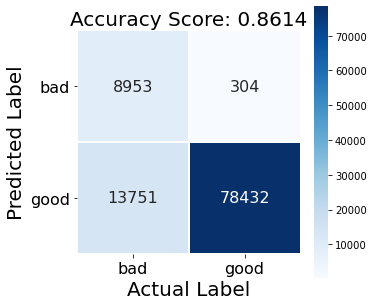

In [11]:
score_xgb_count = lgbm_clf.score(test_X_count.astype(np.float64), y_test.astype(np.float64))
predictions_xgb_count =lgbm_clf.predict(test_X_count.astype(np.float64))
cmatrix_xgb_count = confusion_matrix(predictions_xgb_count, y_test.astype(np.float64))
creport_xgb_count = classification_report(predictions_xgb_count, y_test.astype(np.float64))

print("\n### Model Built ###\n")
generate_report(cmatrix_xgb_count, score_xgb_count, creport_xgb_count)

In [12]:
print("score on test: " + str(lgbm_clf.score(test_X_count.astype(np.float64), y_test.astype(np.float64))))
print("score on train: "+ str(lgbm_clf.score(count_vectorizer_X_train.astype(np.float64),y_train.astype(np.float64))))

score on test: 0.8614451892744479
score on train: 0.8609657035262571


In [13]:
lgbm_clf_tfid = lgbm.LGBMClassifier(boosting_type='gbdt', objective='binary')
lgbm_clf_tfid.fit(tfidf_vectorizer_X_train,y_train.astype(np.float64))

LGBMClassifier(objective='binary')


### Model Built ###

              precision    recall  f1-score   support

         0.0       0.66      0.94      0.77     15919
         1.0       0.99      0.91      0.95     85521

    accuracy                           0.91    101440
   macro avg       0.82      0.92      0.86    101440
weighted avg       0.93      0.91      0.92    101440



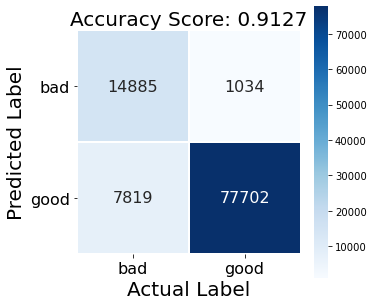

score on test: 0.9127267350157728
score on train: 0.9179777994656887


In [14]:
score_xgb_count = lgbm_clf_tfid.score(test_X_tfidf, y_test.astype(np.float64))
predictions_xgb_count =lgbm_clf_tfid.predict(test_X_tfidf)
cmatrix_xgb_count = confusion_matrix(predictions_xgb_count, y_test.astype(np.float64))
creport_xgb_count = classification_report(predictions_xgb_count, y_test.astype(np.float64))

print("\n### Model Built ###\n")
generate_report(cmatrix_xgb_count, score_xgb_count, creport_xgb_count)
print("score on test: " + str(lgbm_clf_tfid.score(test_X_tfidf, y_test.astype(np.float64))))
print("score on train: "+ str(lgbm_clf_tfid.score(tfidf_vectorizer_X_train,y_train.astype(np.float64))))


### Model Built ###

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     21496
           1       0.99      0.98      0.98     79944

    accuracy                           0.98    101440
   macro avg       0.96      0.97      0.97    101440
weighted avg       0.98      0.98      0.98    101440



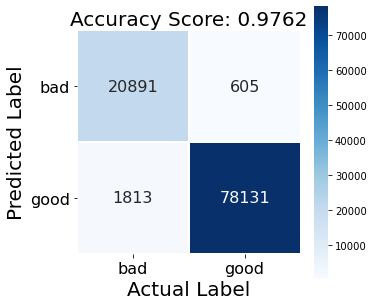

In [252]:

# Train the model
mnb_tfidf = MultinomialNB(alpha = .1)
mnb_tfidf.fit(tfidf_vectorizer_X_train,y_train)


# Test the mode (score, predictions, confusion matrix, classification report)
score_mnb_tfidf = mnb_tfidf.score(test_X_tfidf, y_test)
predictions_mnb_tfidf = mnb_tfidf.predict(test_X_tfidf)
cmatrix_mnb_tfidf = confusion_matrix(predictions_mnb_tfidf,y_test )
creport_mnb_tfidf = classification_report(predictions_mnb_tfidf, y_test)

print("\n### Model Built ###\n")
generate_report(cmatrix_mnb_tfidf, score_mnb_tfidf, creport_mnb_tfidf)


In [253]:
print("score on test: " + str(mnb_tfidf.score(test_X_tfidf, y_test)))
print("score on train: "+ str(mnb_tfidf.score(tfidf_vectorizer_X_train,y_train)))

score on test: 0.9761632492113564
score on train: 0.999179309732943



### Model Built ###

              precision    recall  f1-score   support

           0       0.93      0.96      0.94     21987
           1       0.99      0.98      0.98     79453

    accuracy                           0.97    101440
   macro avg       0.96      0.97      0.96    101440
weighted avg       0.98      0.97      0.97    101440



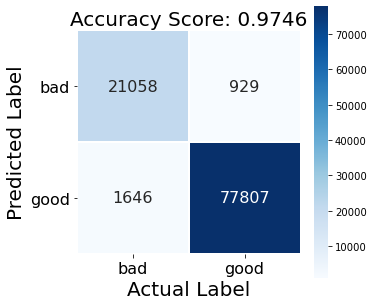

score on test: 0.9746155362776026
score on train: 0.9982945415471367


In [254]:
# Train the model
mnb_count =  MultinomialNB(alpha=0.1)
mnb_count.fit(count_vectorizer_X_train,y_train)


# Test the mode (score, predictions, confusion matrix, classification report)
score_mnb_tfidf = mnb_count.score(test_X_count, y_test)
predictions_mnb_tfidf = mnb_count.predict(test_X_count)
cmatrix_mnb_tfidf = confusion_matrix(predictions_mnb_tfidf,y_test )
creport_mnb_tfidf = classification_report(predictions_mnb_tfidf, y_test)

print("\n### Model Built ###\n")
generate_report(cmatrix_mnb_tfidf, score_mnb_tfidf, creport_mnb_tfidf)
print("score on test: " + str(mnb_count.score(test_X_count, y_test)))
print("score on train: "+ str(mnb_count.score(count_vectorizer_X_train,y_train)))


### Model Built ###

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     23266
           1       0.98      0.99      0.98     78174

    accuracy                           0.97    101440
   macro avg       0.96      0.96      0.96    101440
weighted avg       0.97      0.97      0.97    101440



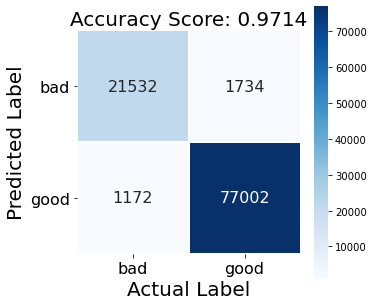

score on test: 0.971352523659306
score on train: 0.9858313863504174


In [255]:
# Train the model
cnb_tfidf = ComplementNB()
cnb_tfidf.fit(tfidf_vectorizer_X_train,y_train)


# Test the mode (score, predictions, confusion matrix, classification report)
score_mnb_tfidf = cnb_tfidf.score(test_X_tfidf, y_test)
predictions_mnb_tfidf = cnb_tfidf.predict(test_X_tfidf)
cmatrix_mnb_tfidf = confusion_matrix(predictions_mnb_tfidf,y_test )
creport_mnb_tfidf = classification_report(predictions_mnb_tfidf, y_test)

print("\n### Model Built ###\n")
generate_report(cmatrix_mnb_tfidf, score_mnb_tfidf, creport_mnb_tfidf)
print("score on test: " + str(cnb_tfidf.score(test_X_tfidf, y_test)))
print("score on train: "+ str(cnb_tfidf.score(tfidf_vectorizer_X_train,y_train)))


### Model Built ###

              precision    recall  f1-score   support

           0       0.97      0.90      0.93     24435
           1       0.97      0.99      0.98     77005

    accuracy                           0.97    101440
   macro avg       0.97      0.94      0.95    101440
weighted avg       0.97      0.97      0.97    101440



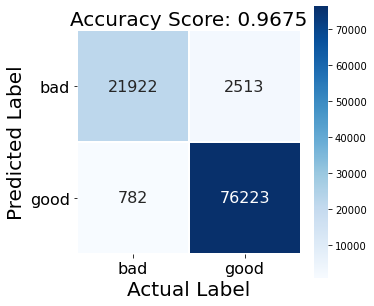

score on test: 0.9675177444794952
score on train: 0.9973530890485908


In [256]:
# Train the model
cnb_count = ComplementNB(alpha = 0.1)
cnb_count.fit(count_vectorizer_X_train,y_train)


# Test the mode (score, predictions, confusion matrix, classification report)
score_mnb_tfidf = cnb_count.score(test_X_count, y_test)
predictions_mnb_tfidf = cnb_count.predict(test_X_count)
cmatrix_mnb_tfidf = confusion_matrix(predictions_mnb_tfidf,y_test )
creport_mnb_tfidf = classification_report(predictions_mnb_tfidf, y_test)

print("\n### Model Built ###\n")
generate_report(cmatrix_mnb_tfidf, score_mnb_tfidf, creport_mnb_tfidf)
print("score on test: " + str(cnb_count.score(test_X_count, y_test)))
print("score on train: "+ str(cnb_count.score(count_vectorizer_X_train,y_train)))


### Model Built ###

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     21043
           1       0.99      0.97      0.98     80397

    accuracy                           0.97    101440
   macro avg       0.95      0.98      0.96    101440
weighted avg       0.98      0.97      0.97    101440



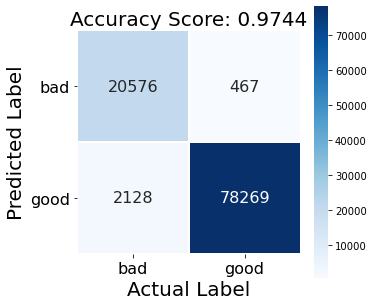

score on test: 0.9744183753943217
score on train: 0.9999827482526444


In [257]:
# Train the model
svc = LinearSVC(max_iter=10000)
svc.fit(count_vectorizer_X_train,y_train)


# Test the mode (score, predictions, confusion matrix, classification report)
score_svc_tfidf = svc.score(test_X_count, y_test)
predictions_svc_tfidf = svc.predict(test_X_count)
cmatrix_svc_tfidf = confusion_matrix(predictions_svc_tfidf,y_test )
creport_svc_tfidf = classification_report(predictions_svc_tfidf, y_test)

print("\n### Model Built ###\n")
generate_report(cmatrix_svc_tfidf, score_svc_tfidf, creport_svc_tfidf)
print("score on test: " + str(svc.score(test_X_count, y_test)))
print("score on train: "+ str(svc.score(count_vectorizer_X_train,y_train)))


### Model Built ###

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     21604
           1       0.99      0.98      0.98     79836

    accuracy                           0.97    101440
   macro avg       0.96      0.97      0.96    101440
weighted avg       0.98      0.97      0.98    101440



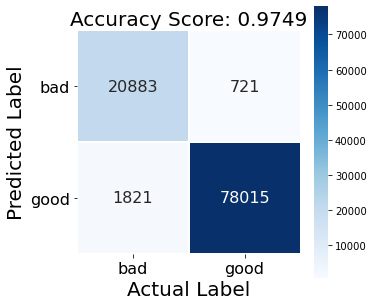

score on test: 0.9749408517350158
score on train: 0.999820088920435


In [258]:
# Train the model
svc_tfidf = LinearSVC()
svc_tfidf.fit(tfidf_vectorizer_X_train,y_train)


# Test the mode (score, predictions, confusion matrix, classification report)
score_mnb_tfidf = svc_tfidf.score(test_X_tfidf, y_test)
predictions_mnb_tfidf = svc_tfidf.predict(test_X_tfidf)
cmatrix_mnb_tfidf = confusion_matrix(predictions_mnb_tfidf,y_test )
creport_mnb_tfidf = classification_report(predictions_mnb_tfidf, y_test)

print("\n### Model Built ###\n")
generate_report(cmatrix_mnb_tfidf, score_mnb_tfidf, creport_mnb_tfidf)
print("score on test: " + str(svc_tfidf.score(test_X_tfidf, y_test)))
print("score on train: "+ str(svc_tfidf.score(tfidf_vectorizer_X_train,y_train)))


### Model Built ###

              precision    recall  f1-score   support

           0       0.88      0.97      0.92     20445
           1       0.99      0.97      0.98     80995

    accuracy                           0.97    101440
   macro avg       0.94      0.97      0.95    101440
weighted avg       0.97      0.97      0.97    101440



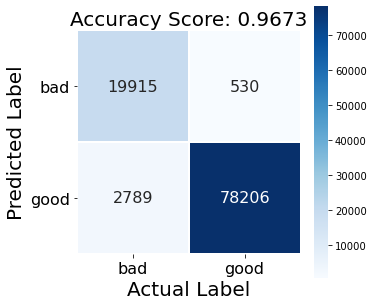

score on test: 0.9672811514195584
score on train: 0.9885645560386045


In [22]:
# Logistic Regression with Count Vectorizer

# Train the model
lgs_count = LogisticRegression(solver='saga' , multi_class="ovr" , max_iter=1000)
lgs_count.fit(count_vectorizer_X_train,y_train)


# Test the mode (score, predictions, confusion matrix, classification report)
score_lgs_count = lgs_count.score(test_X_count, y_test)
predictions_lgs_count = lgs_count.predict(test_X_count)
cmatrix_lgs_count = confusion_matrix(predictions_lgs_count, y_test)
creport_lgs_count = classification_report(predictions_lgs_count, y_test)

print("\n### Model Built ###\n")
generate_report(cmatrix_lgs_count, score_lgs_count, creport_lgs_count)
print("score on test: " + str(lgs_count.score(test_X_count, y_test)))
print("score on train: "+ str(lgs_count.score(count_vectorizer_X_train,y_train)))


### Model Built ###

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     20273
           1       0.99      0.96      0.97     81167

    accuracy                           0.96    101440
   macro avg       0.92      0.96      0.94    101440
weighted avg       0.96      0.96      0.96    101440



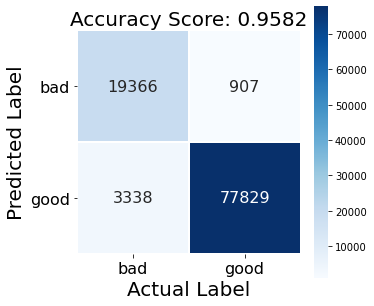

score on test: 0.9581526025236593
score on train: 0.9682222813710702


In [23]:
# Logistic Regression with Count Vectorizer

# Train the model
lgs_tfidf = LogisticRegression(solver='saga', multi_class="ovr" , max_iter=1000)
lgs_tfidf.fit(tfidf_vectorizer_X_train,y_train)


# Test the mode (score, predictions, confusion matrix, classification report)
score_lgs_tfidf = lgs_tfidf.score(test_X_tfidf, y_test)
predictions_lgs_tfidf = lgs_tfidf.predict(test_X_tfidf)
cmatrix_lgs_tfidf = confusion_matrix(predictions_lgs_tfidf, y_test)
creport_lgs_tfidf = classification_report(predictions_lgs_tfidf, y_test)

print("\n### Model Built ###\n")
generate_report(cmatrix_lgs_tfidf, score_lgs_tfidf, creport_lgs_tfidf)
print("score on test: " + str(lgs_tfidf.score(test_X_tfidf, y_test)))
print("score on train: "+ str(lgs_tfidf.score(tfidf_vectorizer_X_train,y_train)))


### Model Built ###

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     21796
           1       0.99      0.98      0.99     79644

    accuracy                           0.98    101440
   macro avg       0.96      0.97      0.97    101440
weighted avg       0.98      0.98      0.98    101440



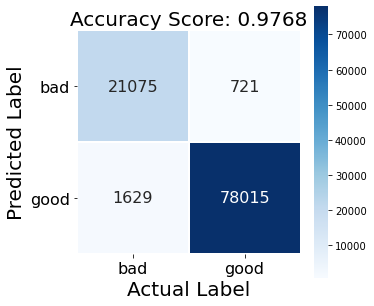

score on test: 0.976833596214511
score on train: 0.9998102307790889


In [259]:
# Train the model
sgd_tfidf = SGDClassifier(n_jobs=-1 , alpha=0.000001)
sgd_tfidf.fit(tfidf_vectorizer_X_train,y_train)


# Test the mode (score, predictions, confusion matrix, classification report)
score_mnb_tfidf = sgd_tfidf.score(test_X_tfidf, y_test)
predictions_mnb_tfidf = sgd_tfidf.predict(test_X_tfidf)
cmatrix_mnb_tfidf = confusion_matrix(predictions_mnb_tfidf,y_test )
creport_mnb_tfidf = classification_report(predictions_mnb_tfidf, y_test)

print("\n### Model Built ###\n")
generate_report(cmatrix_mnb_tfidf, score_mnb_tfidf, creport_mnb_tfidf)
print("score on test: " + str(sgd_tfidf.score(test_X_tfidf, y_test)))
print("score on train: "+ str(sgd_tfidf.score(tfidf_vectorizer_X_train,y_train)))


### Model Built ###

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     21142
           1       0.99      0.97      0.98     80298

    accuracy                           0.97    101440
   macro avg       0.95      0.98      0.96    101440
weighted avg       0.98      0.97      0.97    101440



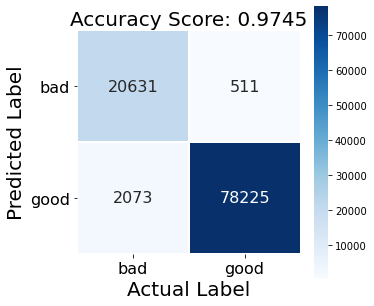

score on test: 0.9745268138801262
score on train: 0.9999654965052889


In [260]:
# Train the model
sgd_count = SGDClassifier(n_jobs=-1 , alpha=0.000001)
sgd_count.fit(count_vectorizer_X_train,y_train)


# Test the mode (score, predictions, confusion matrix, classification report)
score_mnb_tfidf = sgd_count.score(test_X_count, y_test)
predictions_mnb_tfidf = sgd_count.predict(test_X_count)
cmatrix_mnb_tfidf = confusion_matrix(predictions_mnb_tfidf,y_test )
creport_mnb_tfidf = classification_report(predictions_mnb_tfidf, y_test)

print("\n### Model Built ###\n")
generate_report(cmatrix_mnb_tfidf, score_mnb_tfidf, creport_mnb_tfidf)
print("score on test: " + str(sgd_count.score(test_X_count, y_test)))
print("score on train: "+ str(sgd_count.score(count_vectorizer_X_train,y_train)))


### Model Built ###

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     22351
           1       0.99      0.98      0.99     79089

    accuracy                           0.98    101440
   macro avg       0.96      0.97      0.97    101440
weighted avg       0.98      0.98      0.98    101440



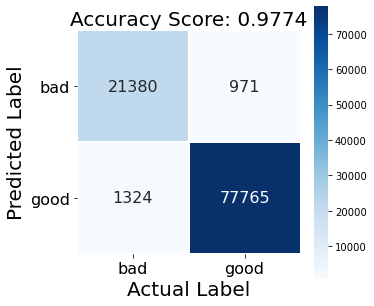

score on test: 0.9773757886435331
score on train: 0.9995760999221207


In [261]:
# Voting Classifier
# 1) multinomialNB tfidf : mnb_tfidf
# 2) ComplementNB tfidf : cnb_tfidf 
# 3) Support Vector Machines tfidf : svc_tfidf
# 4) SGDClassifier tfidf : sgd_tfidf
evc=VotingClassifier(estimators=[('sgd_tfidf' , sgd_tfidf),('mnb_tfidf',mnb_tfidf),('cnb_tfidf',cnb_tfidf),('svc_tfidf',svc_tfidf)],voting='hard')
evc.fit(tfidf_vectorizer_X_train,y_train)

# Test the mode (score, predictions, confusion matrix, classification report)
score_evc_tfidf = evc.score(test_X_tfidf, y_test)
predictions_evc_tfidf = evc.predict(test_X_tfidf)
cmatrix_evc_tfidf = confusion_matrix(predictions_evc_tfidf, y_test)
creport_evc_tfidf = classification_report(predictions_evc_tfidf, y_test)

print("\n### Model Built ###\n")
generate_report(cmatrix_evc_tfidf, score_evc_tfidf, creport_evc_tfidf)
print("score on test: " + str(evc.score(test_X_tfidf, y_test)))
print("score on train: "+ str(evc.score(tfidf_vectorizer_X_train,y_train)))



### Model Built ###

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     22464
           1       0.99      0.98      0.98     78976

    accuracy                           0.98    101440
   macro avg       0.96      0.97      0.96    101440
weighted avg       0.98      0.98      0.98    101440



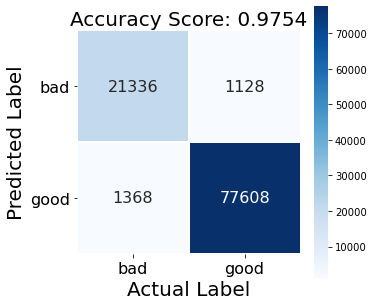

score on test: 0.9753943217665615
score on train: 0.9987406224430446


In [262]:
# Voting Classifier
# 1) multinomialNB tfidf : mnb_count
# 2) ComplementNB count : cnb_count
# 3) Support Vector Machines count : svc
# 4) Logistic Regression count : lgs_count
evc_count=VotingClassifier(estimators=[('sgd_count' , sgd_count) , ('mnb_count',mnb_count),('cnb_count',cnb_count),('svc',svc)],voting='hard')
evc_count.fit(count_vectorizer_X_train,y_train)

# Test the mode (score, predictions, confusion matrix, classification report)
score_evc_tfidf = evc_count.score(test_X_count, y_test)
predictions_evc_tfidf = evc_count.predict(test_X_count)
cmatrix_evc_tfidf = confusion_matrix(predictions_evc_tfidf, y_test)
creport_evc_tfidf = classification_report(predictions_evc_tfidf, y_test)

print("\n### Model Built ###\n")
generate_report(cmatrix_evc_tfidf, score_evc_tfidf, creport_evc_tfidf)
print("score on test: " + str(evc_count.score(test_X_count, y_test)))
print("score on train: "+ str(evc_count.score(count_vectorizer_X_train,y_train)))



### Model Built ###

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     22463
           1       0.99      0.98      0.99     78977

    accuracy                           0.98    101440
   macro avg       0.97      0.97      0.97    101440
weighted avg       0.98      0.98      0.98    101440



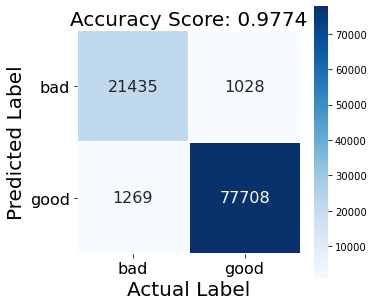

score on test: 0.9773560725552051
score on train: 0.9995958162048127


In [263]:
# Voting Classifier
# 1) Voting clasifier tfid : evc
# 2) Voting classifier count : evc_count

evc_final=VotingClassifier(estimators=[('evc' , evc), ('evc_count' , evc_count)],voting='hard')
evc_final.fit(tfidf_vectorizer_X_train,y_train)

# Test the mode (score, predictions, confusion matrix, classification report)
score_evc_tfidf = evc_final.score(test_X_tfidf, y_test)
predictions_evc_tfidf = evc_final.predict(test_X_tfidf)
cmatrix_evc_tfidf = confusion_matrix(predictions_evc_tfidf, y_test)
creport_evc_tfidf = classification_report(predictions_evc_tfidf, y_test)

print("\n### Model Built ###\n")
generate_report(cmatrix_evc_tfidf, score_evc_tfidf, creport_evc_tfidf)
print("score on test: " + str(evc_final.score(test_X_tfidf, y_test)))
print("score on train: "+ str(evc_final.score(tfidf_vectorizer_X_train,y_train)))

In [1]:
# Testing
lst = ["https://deadlocked-streets.000webhostapp.com/" , "https://askubuntu.com/questions/624848/view-history-of-commands-run-in-terminal" , "https://github.com/tiangolo/fastapi" , "https://github.com/tiangolo/fastapi/issues/2293"]

In [2]:
test=count_vectorizer.transform(lst)

NameError: name 'count_vectorizer' is not defined

In [330]:
sgd_tfidf.predict(test)

array([1, 1, 1, 1])

In [331]:
evc.predict(test)

array([0, 1, 0, 1])

In [332]:
mnb_tfidf.predict(test)

array([0, 0, 0, 1])

In [333]:
evc_final.predict(test)

array([0, 0, 0, 1])

In [278]:
#dump(evc_final, 'voting_model.joblib') 

In [272]:
dump(svc_tfidf , 'svc_tfidf.joblib')
dump(sgd_tfidf , 'sgd_tfidf.joblib')

['sgd_tfidf.joblib']